<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-eddiephelanfortyfive/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [2]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [3]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # TODO: define the transformation for the test set (without any data augmentation)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # TODO: define the transformation for the train set (with data augmentation)
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),  # randomly rotate by ±10 degrees
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform



## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [7]:
from torch.utils.data import DataLoader

def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    # TODO: download the FashionMNIST dataset
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=train_transform
        )
    test_dataset  = torchvision.datasets.FashionMNIST(
        root='./data', train=True, download=True, transform=train_transform
        )

    # TODO: create the data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

Train set size: 60000
Test set size: 60000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [8]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization

        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        if self.useRegularization:
            # TODO: Add dropout layer if regularization is enabled
            self.dropout = nn.Dropout(p=dropout_prob)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # TODO: Define fully connected layers after flattening
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # TODO: Define forward pass logic with appropriate activation and pooling
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        if self.useRegularization:
            x = self.dropout(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        if self.useRegularization:
            x = self.dropout(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        if self.useRegularization:
            x = self.dropout(x)

        out = self.fc2(x)
        return out


## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [9]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [10]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)


In [11]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301290  [   64/60000]
loss: 0.357260  [ 6464/60000]
loss: 0.524956  [12864/60000]
loss: 0.340027  [19264/60000]
loss: 0.161115  [25664/60000]
loss: 0.525546  [32064/60000]
loss: 0.238993  [38464/60000]
loss: 0.221852  [44864/60000]
loss: 0.252920  [51264/60000]
loss: 0.416224  [57664/60000]


Epochs:  10%|█         | 1/10 [00:46<06:59, 46.59s/it]

Train Error: 
 Accuracy: 92.0%, Avg loss: 0.219501 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.219519 

Epoch 2:

loss: 0.285402  [   64/60000]
loss: 0.247843  [ 6464/60000]
loss: 0.216631  [12864/60000]
loss: 0.362281  [19264/60000]
loss: 0.200985  [25664/60000]
loss: 0.335830  [32064/60000]
loss: 0.092395  [38464/60000]
loss: 0.254772  [44864/60000]
loss: 0.098329  [51264/60000]
loss: 0.122695  [57664/60000]


Epochs:  20%|██        | 2/10 [01:31<06:05, 45.64s/it]

Train Error: 
 Accuracy: 94.6%, Avg loss: 0.153026 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.153016 

Epoch 3:

loss: 0.153236  [   64/60000]
loss: 0.080115  [ 6464/60000]
loss: 0.205403  [12864/60000]
loss: 0.160258  [19264/60000]
loss: 0.092390  [25664/60000]
loss: 0.118410  [32064/60000]
loss: 0.196577  [38464/60000]
loss: 0.158173  [44864/60000]
loss: 0.138114  [51264/60000]
loss: 0.145754  [57664/60000]


Epochs:  30%|███       | 3/10 [02:16<05:18, 45.49s/it]

Train Error: 
 Accuracy: 94.9%, Avg loss: 0.137115 

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.137137 

Epoch 4:

loss: 0.082709  [   64/60000]
loss: 0.091171  [ 6464/60000]
loss: 0.203785  [12864/60000]
loss: 0.156461  [19264/60000]
loss: 0.090092  [25664/60000]
loss: 0.120272  [32064/60000]
loss: 0.210139  [38464/60000]
loss: 0.017977  [44864/60000]
loss: 0.060514  [51264/60000]
loss: 0.063363  [57664/60000]


Epochs:  40%|████      | 4/10 [03:01<04:31, 45.19s/it]

Train Error: 
 Accuracy: 96.3%, Avg loss: 0.102138 

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.102075 

Epoch 5:

loss: 0.102816  [   64/60000]
loss: 0.126318  [ 6464/60000]
loss: 0.229755  [12864/60000]
loss: 0.108858  [19264/60000]
loss: 0.042993  [25664/60000]
loss: 0.064009  [32064/60000]
loss: 0.081067  [38464/60000]
loss: 0.025615  [44864/60000]
loss: 0.075782  [51264/60000]
loss: 0.120435  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:46<03:45, 45.11s/it]

Train Error: 
 Accuracy: 97.5%, Avg loss: 0.069440 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.069527 

Epoch 6:

loss: 0.032570  [   64/60000]
loss: 0.105851  [ 6464/60000]
loss: 0.096432  [12864/60000]
loss: 0.021005  [19264/60000]
loss: 0.043020  [25664/60000]
loss: 0.072960  [32064/60000]
loss: 0.059923  [38464/60000]
loss: 0.113956  [44864/60000]
loss: 0.131879  [51264/60000]
loss: 0.139686  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:31<02:59, 44.92s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.044432 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.044430 

Epoch 7:

loss: 0.040679  [   64/60000]
loss: 0.062617  [ 6464/60000]
loss: 0.029671  [12864/60000]
loss: 0.042107  [19264/60000]
loss: 0.063393  [25664/60000]
loss: 0.017190  [32064/60000]
loss: 0.034496  [38464/60000]
loss: 0.029239  [44864/60000]
loss: 0.052979  [51264/60000]
loss: 0.023435  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:15<02:14, 44.69s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.032663 

Test Error: 
 Accuracy: 98.9%, Avg loss: 0.032624 

Epoch 8:

loss: 0.042231  [   64/60000]
loss: 0.021663  [ 6464/60000]
loss: 0.007657  [12864/60000]
loss: 0.045888  [19264/60000]
loss: 0.090629  [25664/60000]
loss: 0.019593  [32064/60000]
loss: 0.028338  [38464/60000]
loss: 0.008643  [44864/60000]
loss: 0.034243  [51264/60000]
loss: 0.024314  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:00<01:29, 44.82s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.038972 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.038966 

Epoch 9:

loss: 0.097306  [   64/60000]
loss: 0.004445  [ 6464/60000]
loss: 0.002560  [12864/60000]
loss: 0.026452  [19264/60000]
loss: 0.021727  [25664/60000]
loss: 0.008126  [32064/60000]
loss: 0.030698  [38464/60000]
loss: 0.021339  [44864/60000]
loss: 0.013875  [51264/60000]
loss: 0.024394  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:45<00:45, 45.02s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.029572 

Test Error: 
 Accuracy: 98.9%, Avg loss: 0.029523 

Epoch 10:

loss: 0.020421  [   64/60000]
loss: 0.001718  [ 6464/60000]
loss: 0.112580  [12864/60000]
loss: 0.003265  [19264/60000]
loss: 0.072326  [25664/60000]
loss: 0.006879  [32064/60000]
loss: 0.023086  [38464/60000]
loss: 0.002293  [44864/60000]
loss: 0.003193  [51264/60000]
loss: 0.009665  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:31<00:00, 45.10s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.025205 

Test Error: 
 Accuracy: 99.1%, Avg loss: 0.025315 

Done training!


Plotting metrics

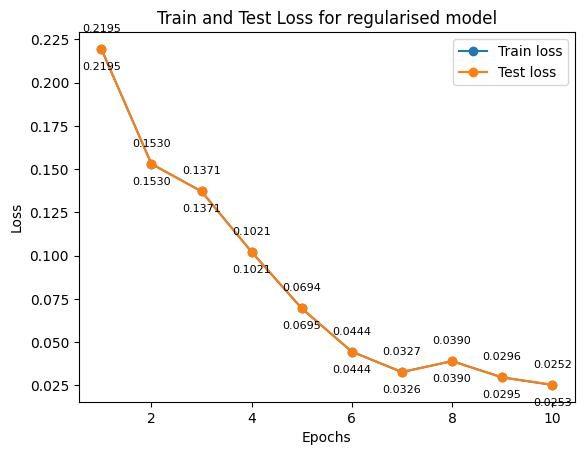

In [12]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

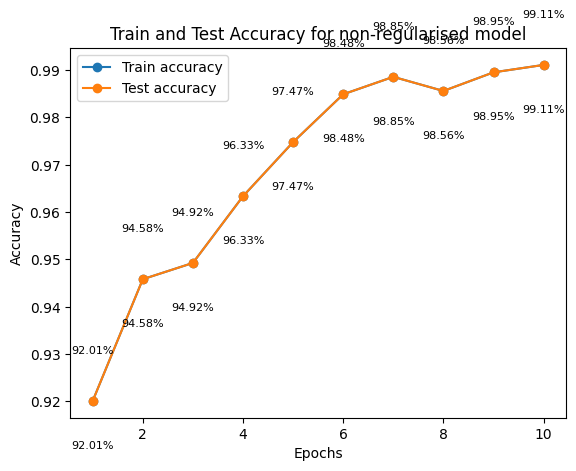

In [13]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [14]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)

epochs = 10  # Increasing the number of epochs by 5 since the learning will be more gradual.

optimiser = optim.Adam(model.parameters(), lr=0.001)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimiser, epochs
)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.302036  [   64/60000]
loss: 0.460334  [ 6464/60000]
loss: 0.486808  [12864/60000]
loss: 0.441413  [19264/60000]
loss: 0.246656  [25664/60000]
loss: 0.370701  [32064/60000]
loss: 0.448742  [38464/60000]
loss: 0.323672  [44864/60000]
loss: 0.132700  [51264/60000]
loss: 0.133833  [57664/60000]


Epochs:  10%|█         | 1/10 [01:07<10:07, 67.53s/it]

Train Error: 
 Accuracy: 88.6%, Avg loss: 0.309942 

Test Error: 
 Accuracy: 88.6%, Avg loss: 0.310045 

Epoch 2:

loss: 0.326110  [   64/60000]
loss: 0.400691  [ 6464/60000]
loss: 0.340553  [12864/60000]
loss: 0.330971  [19264/60000]
loss: 0.277596  [25664/60000]
loss: 0.305881  [32064/60000]
loss: 0.208443  [38464/60000]
loss: 0.266811  [44864/60000]
loss: 0.371770  [51264/60000]
loss: 0.342282  [57664/60000]


Epochs:  20%|██        | 2/10 [02:13<08:54, 66.84s/it]

Train Error: 
 Accuracy: 91.0%, Avg loss: 0.245406 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.246218 

Epoch 3:

loss: 0.279135  [   64/60000]
loss: 0.315968  [ 6464/60000]
loss: 0.385202  [12864/60000]
loss: 0.192326  [19264/60000]
loss: 0.208963  [25664/60000]
loss: 0.181679  [32064/60000]
loss: 0.288850  [38464/60000]
loss: 0.350176  [44864/60000]
loss: 0.096414  [51264/60000]
loss: 0.188863  [57664/60000]


Epochs:  30%|███       | 3/10 [03:20<07:48, 66.91s/it]

Train Error: 
 Accuracy: 91.8%, Avg loss: 0.221157 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.220759 

Epoch 4:

loss: 0.236138  [   64/60000]
loss: 0.290331  [ 6464/60000]
loss: 0.286347  [12864/60000]
loss: 0.277780  [19264/60000]
loss: 0.460814  [25664/60000]
loss: 0.256815  [32064/60000]
loss: 0.285801  [38464/60000]
loss: 0.278525  [44864/60000]
loss: 0.302499  [51264/60000]
loss: 0.322571  [57664/60000]


Epochs:  40%|████      | 4/10 [04:27<06:41, 66.85s/it]

Train Error: 
 Accuracy: 92.4%, Avg loss: 0.204078 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.205393 

Epoch 5:

loss: 0.292572  [   64/60000]
loss: 0.226990  [ 6464/60000]
loss: 0.307808  [12864/60000]
loss: 0.095146  [19264/60000]
loss: 0.166620  [25664/60000]
loss: 0.147383  [32064/60000]
loss: 0.291481  [38464/60000]
loss: 0.256914  [44864/60000]
loss: 0.105211  [51264/60000]
loss: 0.275344  [57664/60000]


Epochs:  50%|█████     | 5/10 [05:35<05:35, 67.19s/it]

Train Error: 
 Accuracy: 92.9%, Avg loss: 0.193636 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.194340 

Epoch 6:

loss: 0.286477  [   64/60000]
loss: 0.158638  [ 6464/60000]
loss: 0.270645  [12864/60000]
loss: 0.250870  [19264/60000]
loss: 0.147296  [25664/60000]
loss: 0.209710  [32064/60000]
loss: 0.078617  [38464/60000]
loss: 0.164229  [44864/60000]
loss: 0.215591  [51264/60000]
loss: 0.218579  [57664/60000]


Epochs:  60%|██████    | 6/10 [06:42<04:29, 67.27s/it]

Train Error: 
 Accuracy: 92.6%, Avg loss: 0.197914 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.198937 

Epoch 7:

loss: 0.319346  [   64/60000]
loss: 0.177687  [ 6464/60000]
loss: 0.327721  [12864/60000]
loss: 0.101836  [19264/60000]
loss: 0.167652  [25664/60000]
loss: 0.184522  [32064/60000]
loss: 0.146015  [38464/60000]
loss: 0.266890  [44864/60000]
loss: 0.123655  [51264/60000]
loss: 0.412326  [57664/60000]


Epochs:  70%|███████   | 7/10 [07:50<03:22, 67.49s/it]

Train Error: 
 Accuracy: 93.6%, Avg loss: 0.172678 

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.170660 

Epoch 8:

loss: 0.221191  [   64/60000]
loss: 0.167871  [ 6464/60000]
loss: 0.312266  [12864/60000]
loss: 0.121657  [19264/60000]
loss: 0.156080  [25664/60000]
loss: 0.116395  [32064/60000]
loss: 0.147582  [38464/60000]
loss: 0.080584  [44864/60000]
loss: 0.138776  [51264/60000]
loss: 0.216410  [57664/60000]


Epochs:  80%|████████  | 8/10 [08:58<02:15, 67.62s/it]

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.175347 

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.175011 

Epoch 9:

loss: 0.297792  [   64/60000]
loss: 0.329980  [ 6464/60000]
loss: 0.197271  [12864/60000]
loss: 0.140601  [19264/60000]
loss: 0.122489  [25664/60000]
loss: 0.156035  [32064/60000]
loss: 0.228337  [38464/60000]
loss: 0.234131  [44864/60000]
loss: 0.297291  [51264/60000]
loss: 0.171120  [57664/60000]


Epochs:  90%|█████████ | 9/10 [10:05<01:07, 67.41s/it]

Train Error: 
 Accuracy: 94.3%, Avg loss: 0.155373 

Test Error: 
 Accuracy: 94.3%, Avg loss: 0.152901 

Epoch 10:

loss: 0.127054  [   64/60000]
loss: 0.115582  [ 6464/60000]
loss: 0.152463  [12864/60000]
loss: 0.212461  [19264/60000]
loss: 0.258500  [25664/60000]
loss: 0.384845  [32064/60000]
loss: 0.197839  [38464/60000]
loss: 0.117178  [44864/60000]
loss: 0.167869  [51264/60000]
loss: 0.170460  [57664/60000]


Epochs: 100%|██████████| 10/10 [11:12<00:00, 67.22s/it]

Train Error: 
 Accuracy: 94.4%, Avg loss: 0.151626 

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.150021 

Done training!


Plotting metrics

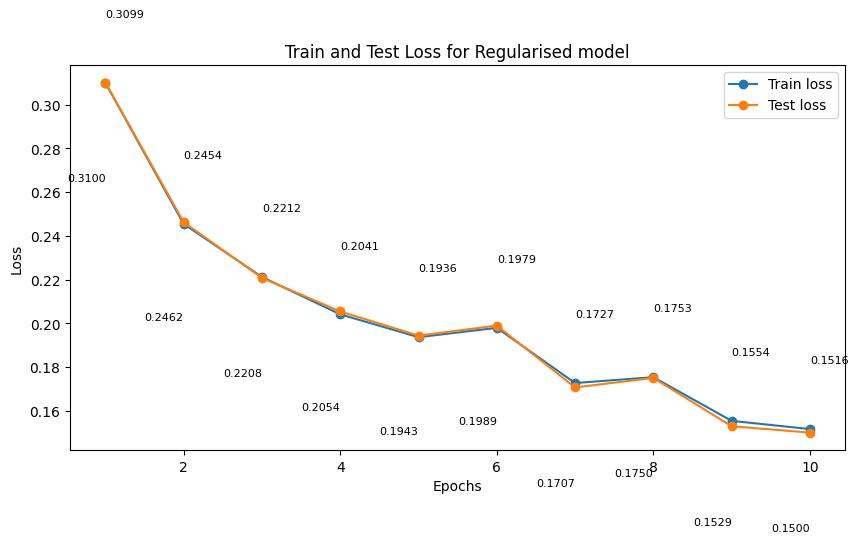

In [15]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

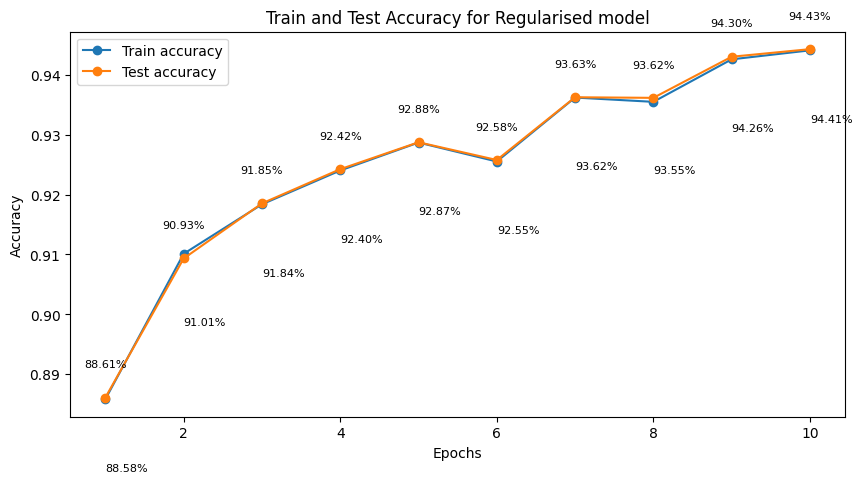

In [16]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [18]:
# Apply only regularisation on the cnn model
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(dropout_prob=0.3, useRegularization=True).to(device)

epochs = 10

optimiser = optim.Adam(model.parameters(), lr=0.001)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimiser, epochs
)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300088  [   64/60000]
loss: 0.571295  [ 6464/60000]
loss: 0.661511  [12864/60000]
loss: 0.449577  [19264/60000]
loss: 0.312568  [25664/60000]
loss: 0.443532  [32064/60000]
loss: 0.285556  [38464/60000]
loss: 0.317744  [44864/60000]
loss: 0.201784  [51264/60000]
loss: 0.341539  [57664/60000]


Epochs:  10%|█         | 1/10 [00:45<06:46, 45.21s/it]

Train Error: 
 Accuracy: 90.9%, Avg loss: 0.249901 

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.249857 

Epoch 2:

loss: 0.245523  [   64/60000]
loss: 0.242881  [ 6464/60000]
loss: 0.243837  [12864/60000]
loss: 0.279675  [19264/60000]
loss: 0.194827  [25664/60000]
loss: 0.236033  [32064/60000]
loss: 0.235642  [38464/60000]
loss: 0.272849  [44864/60000]
loss: 0.285459  [51264/60000]
loss: 0.269508  [57664/60000]


Epochs:  20%|██        | 2/10 [01:30<06:03, 45.41s/it]

Train Error: 
 Accuracy: 93.1%, Avg loss: 0.185986 

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.186009 

Epoch 3:

loss: 0.238266  [   64/60000]
loss: 0.187698  [ 6464/60000]
loss: 0.191374  [12864/60000]
loss: 0.190290  [19264/60000]
loss: 0.161283  [25664/60000]
loss: 0.316337  [32064/60000]
loss: 0.184976  [38464/60000]
loss: 0.286455  [44864/60000]
loss: 0.332170  [51264/60000]
loss: 0.090471  [57664/60000]


Epochs:  30%|███       | 3/10 [02:16<05:19, 45.57s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.174846 

Test Error: 
 Accuracy: 93.7%, Avg loss: 0.174885 

Epoch 4:

loss: 0.233091  [   64/60000]
loss: 0.123267  [ 6464/60000]
loss: 0.199911  [12864/60000]
loss: 0.151481  [19264/60000]
loss: 0.087110  [25664/60000]
loss: 0.337870  [32064/60000]
loss: 0.240398  [38464/60000]
loss: 0.153817  [44864/60000]
loss: 0.266823  [51264/60000]
loss: 0.163833  [57664/60000]


Epochs:  40%|████      | 4/10 [03:02<04:33, 45.60s/it]

Train Error: 
 Accuracy: 94.6%, Avg loss: 0.146591 

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.146586 

Epoch 5:

loss: 0.152187  [   64/60000]
loss: 0.104477  [ 6464/60000]
loss: 0.180821  [12864/60000]
loss: 0.386240  [19264/60000]
loss: 0.157198  [25664/60000]
loss: 0.214531  [32064/60000]
loss: 0.266482  [38464/60000]
loss: 0.071398  [44864/60000]
loss: 0.185987  [51264/60000]
loss: 0.154868  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:47<03:46, 45.39s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.119042 

Test Error: 
 Accuracy: 95.6%, Avg loss: 0.118953 

Epoch 6:

loss: 0.136579  [   64/60000]
loss: 0.260051  [ 6464/60000]
loss: 0.117981  [12864/60000]
loss: 0.158113  [19264/60000]
loss: 0.152831  [25664/60000]
loss: 0.203995  [32064/60000]
loss: 0.124590  [38464/60000]
loss: 0.167747  [44864/60000]
loss: 0.180006  [51264/60000]
loss: 0.272627  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:33<03:02, 45.64s/it]

Train Error: 
 Accuracy: 95.8%, Avg loss: 0.113809 

Test Error: 
 Accuracy: 95.8%, Avg loss: 0.113778 

Epoch 7:

loss: 0.299864  [   64/60000]
loss: 0.096035  [ 6464/60000]
loss: 0.120689  [12864/60000]
loss: 0.038340  [19264/60000]
loss: 0.095731  [25664/60000]
loss: 0.080928  [32064/60000]
loss: 0.109791  [38464/60000]
loss: 0.155728  [44864/60000]
loss: 0.057290  [51264/60000]
loss: 0.139765  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:19<02:17, 45.78s/it]

Train Error: 
 Accuracy: 96.6%, Avg loss: 0.095738 

Test Error: 
 Accuracy: 96.6%, Avg loss: 0.095745 

Epoch 8:

loss: 0.152106  [   64/60000]
loss: 0.130574  [ 6464/60000]
loss: 0.098447  [12864/60000]
loss: 0.138752  [19264/60000]
loss: 0.110983  [25664/60000]
loss: 0.238267  [32064/60000]
loss: 0.092929  [38464/60000]
loss: 0.150769  [44864/60000]
loss: 0.192743  [51264/60000]
loss: 0.177676  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:05<01:31, 45.76s/it]

Train Error: 
 Accuracy: 97.3%, Avg loss: 0.077032 

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.077044 

Epoch 9:

loss: 0.126182  [   64/60000]
loss: 0.160444  [ 6464/60000]
loss: 0.089927  [12864/60000]
loss: 0.196936  [19264/60000]
loss: 0.125955  [25664/60000]
loss: 0.182401  [32064/60000]
loss: 0.052622  [38464/60000]
loss: 0.143191  [44864/60000]
loss: 0.088563  [51264/60000]
loss: 0.106152  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:49<00:45, 45.43s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.066010 

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.065971 

Epoch 10:

loss: 0.075743  [   64/60000]
loss: 0.167424  [ 6464/60000]
loss: 0.040191  [12864/60000]
loss: 0.095657  [19264/60000]
loss: 0.125852  [25664/60000]
loss: 0.119779  [32064/60000]
loss: 0.105937  [38464/60000]
loss: 0.107207  [44864/60000]
loss: 0.472159  [51264/60000]
loss: 0.129876  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:35<00:00, 45.53s/it]

Train Error: 
 Accuracy: 97.9%, Avg loss: 0.059009 

Test Error: 
 Accuracy: 97.9%, Avg loss: 0.059038 

Done training!


Plotting metrics

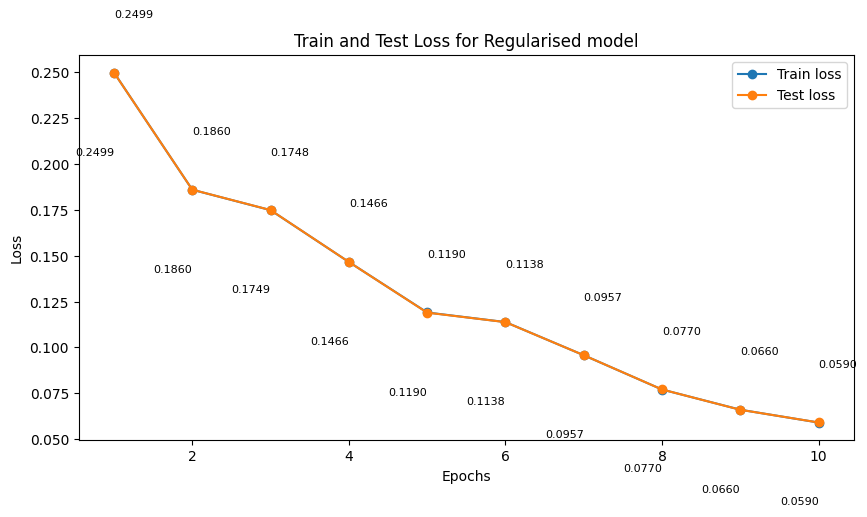

In [19]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

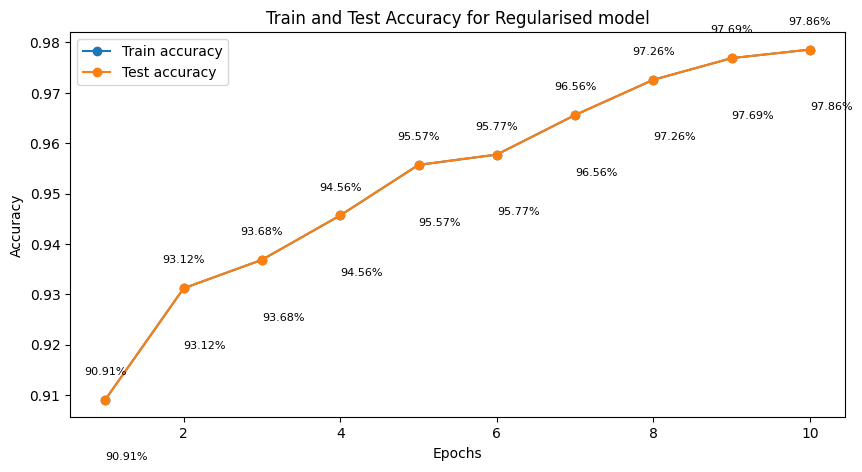

In [20]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [22]:

train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(dropout_prob=0.0, useRegularization=False).to(device)

epochs = 10

optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimiser, epochs
)


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300278  [   64/60000]
loss: 0.316262  [ 6464/60000]
loss: 0.439817  [12864/60000]
loss: 0.413465  [19264/60000]
loss: 0.384843  [25664/60000]
loss: 0.241184  [32064/60000]
loss: 0.116859  [38464/60000]
loss: 0.364483  [44864/60000]
loss: 0.273532  [51264/60000]
loss: 0.205442  [57664/60000]


Epochs:  10%|█         | 1/10 [00:45<06:51, 45.70s/it]

Train Error: 
 Accuracy: 91.1%, Avg loss: 0.243277 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.243168 

Epoch 2:

loss: 0.192565  [   64/60000]
loss: 0.110902  [ 6464/60000]
loss: 0.229693  [12864/60000]
loss: 0.262817  [19264/60000]
loss: 0.147827  [25664/60000]
loss: 0.246414  [32064/60000]
loss: 0.108869  [38464/60000]
loss: 0.322235  [44864/60000]
loss: 0.244891  [51264/60000]
loss: 0.161683  [57664/60000]


Epochs:  20%|██        | 2/10 [01:31<06:03, 45.48s/it]

Train Error: 
 Accuracy: 93.4%, Avg loss: 0.179184 

Test Error: 
 Accuracy: 93.4%, Avg loss: 0.179063 

Epoch 3:

loss: 0.141128  [   64/60000]
loss: 0.165967  [ 6464/60000]
loss: 0.168389  [12864/60000]
loss: 0.255728  [19264/60000]
loss: 0.128439  [25664/60000]
loss: 0.167522  [32064/60000]
loss: 0.276610  [38464/60000]
loss: 0.252167  [44864/60000]
loss: 0.200016  [51264/60000]
loss: 0.139934  [57664/60000]


Epochs:  30%|███       | 3/10 [02:16<05:19, 45.68s/it]

Train Error: 
 Accuracy: 94.7%, Avg loss: 0.144760 

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.144776 

Epoch 4:

loss: 0.106438  [   64/60000]
loss: 0.121990  [ 6464/60000]
loss: 0.268235  [12864/60000]
loss: 0.170206  [19264/60000]
loss: 0.107164  [25664/60000]
loss: 0.183439  [32064/60000]
loss: 0.063218  [38464/60000]
loss: 0.175619  [44864/60000]
loss: 0.097615  [51264/60000]
loss: 0.139031  [57664/60000]


Epochs:  40%|████      | 4/10 [03:03<04:35, 45.98s/it]

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.142333 

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.142368 

Epoch 5:

loss: 0.154878  [   64/60000]
loss: 0.264916  [ 6464/60000]
loss: 0.087526  [12864/60000]
loss: 0.089361  [19264/60000]
loss: 0.122774  [25664/60000]
loss: 0.123237  [32064/60000]
loss: 0.080499  [38464/60000]
loss: 0.150285  [44864/60000]
loss: 0.129574  [51264/60000]
loss: 0.091880  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:49<03:49, 45.95s/it]

Train Error: 
 Accuracy: 96.5%, Avg loss: 0.098134 

Test Error: 
 Accuracy: 96.5%, Avg loss: 0.098056 

Epoch 6:

loss: 0.075555  [   64/60000]
loss: 0.055677  [ 6464/60000]
loss: 0.046016  [12864/60000]
loss: 0.113317  [19264/60000]
loss: 0.147169  [25664/60000]
loss: 0.129886  [32064/60000]
loss: 0.087899  [38464/60000]
loss: 0.121214  [44864/60000]
loss: 0.114850  [51264/60000]
loss: 0.124371  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:35<03:03, 45.88s/it]

Train Error: 
 Accuracy: 97.4%, Avg loss: 0.073938 

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.074004 

Epoch 7:

loss: 0.039008  [   64/60000]
loss: 0.063331  [ 6464/60000]
loss: 0.124244  [12864/60000]
loss: 0.031213  [19264/60000]
loss: 0.039618  [25664/60000]
loss: 0.078346  [32064/60000]
loss: 0.072363  [38464/60000]
loss: 0.207400  [44864/60000]
loss: 0.149069  [51264/60000]
loss: 0.135089  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:22<02:18, 46.27s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.064669 

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.064697 

Epoch 8:

loss: 0.038910  [   64/60000]
loss: 0.189230  [ 6464/60000]
loss: 0.077444  [12864/60000]
loss: 0.093393  [19264/60000]
loss: 0.044112  [25664/60000]
loss: 0.146375  [32064/60000]
loss: 0.016247  [38464/60000]
loss: 0.103585  [44864/60000]
loss: 0.146069  [51264/60000]
loss: 0.081051  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:08<01:32, 46.20s/it]

Train Error: 
 Accuracy: 98.4%, Avg loss: 0.046516 

Test Error: 
 Accuracy: 98.4%, Avg loss: 0.046546 

Epoch 9:

loss: 0.033404  [   64/60000]
loss: 0.026751  [ 6464/60000]
loss: 0.084554  [12864/60000]
loss: 0.047634  [19264/60000]
loss: 0.090764  [25664/60000]
loss: 0.034178  [32064/60000]
loss: 0.043043  [38464/60000]
loss: 0.063764  [44864/60000]
loss: 0.109887  [51264/60000]
loss: 0.084008  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:54<00:46, 46.22s/it]

Train Error: 
 Accuracy: 98.2%, Avg loss: 0.050285 

Test Error: 
 Accuracy: 98.2%, Avg loss: 0.050354 

Epoch 10:

loss: 0.056486  [   64/60000]
loss: 0.012093  [ 6464/60000]
loss: 0.112178  [12864/60000]
loss: 0.053773  [19264/60000]
loss: 0.038232  [25664/60000]
loss: 0.026519  [32064/60000]
loss: 0.113839  [38464/60000]
loss: 0.043096  [44864/60000]
loss: 0.042257  [51264/60000]
loss: 0.162335  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:40<00:00, 46.05s/it]

Train Error: 
 Accuracy: 98.6%, Avg loss: 0.042149 

Test Error: 
 Accuracy: 98.6%, Avg loss: 0.042160 

Done training!


Plotting metrics

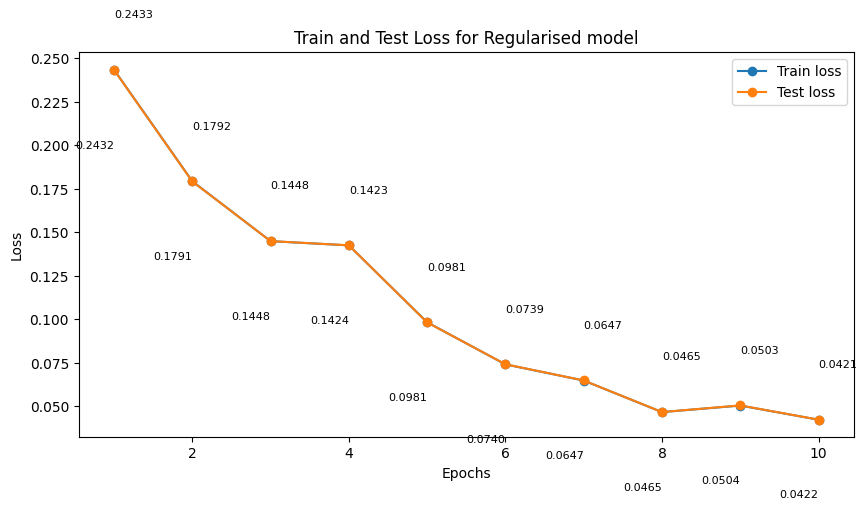

In [23]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

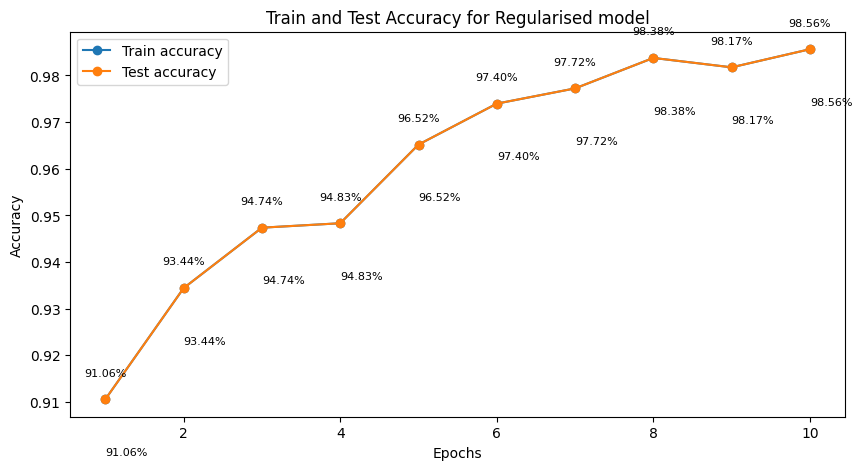

In [24]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [27]:


train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(dropout_prob=0.0, useRegularization=False).to(device)

epochs = 10

optimiser = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

train_loss, train_accuracy, test_loss, test_accuracy = train_loop(
    train_loader, test_loader, model, loss_fn, optimiser, epochs
)



Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.302498  [   64/60000]
loss: 0.406154  [ 6464/60000]
loss: 0.306741  [12864/60000]
loss: 0.502893  [19264/60000]
loss: 0.333877  [25664/60000]
loss: 0.205371  [32064/60000]
loss: 0.269806  [38464/60000]
loss: 0.250281  [44864/60000]
loss: 0.307340  [51264/60000]
loss: 0.473109  [57664/60000]


Epochs:  10%|█         | 1/10 [00:45<06:47, 45.24s/it]

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.278651 

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.278621 

Epoch 2:

loss: 0.256172  [   64/60000]
loss: 0.306768  [ 6464/60000]
loss: 0.173867  [12864/60000]
loss: 0.209794  [19264/60000]
loss: 0.198537  [25664/60000]
loss: 0.267202  [32064/60000]
loss: 0.139782  [38464/60000]
loss: 0.198059  [44864/60000]
loss: 0.362105  [51264/60000]
loss: 0.364435  [57664/60000]


Epochs:  20%|██        | 2/10 [01:30<06:02, 45.31s/it]

Train Error: 
 Accuracy: 91.9%, Avg loss: 0.218324 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.218253 

Epoch 3:

loss: 0.230676  [   64/60000]
loss: 0.162331  [ 6464/60000]
loss: 0.165142  [12864/60000]
loss: 0.323581  [19264/60000]
loss: 0.212949  [25664/60000]
loss: 0.179185  [32064/60000]
loss: 0.323338  [38464/60000]
loss: 0.179159  [44864/60000]
loss: 0.112737  [51264/60000]
loss: 0.213903  [57664/60000]


Epochs:  30%|███       | 3/10 [02:15<05:17, 45.32s/it]

Train Error: 
 Accuracy: 92.3%, Avg loss: 0.208333 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.208250 

Epoch 4:

loss: 0.219087  [   64/60000]
loss: 0.215249  [ 6464/60000]
loss: 0.373177  [12864/60000]
loss: 0.096167  [19264/60000]
loss: 0.322939  [25664/60000]
loss: 0.250995  [32064/60000]
loss: 0.190999  [38464/60000]
loss: 0.113932  [44864/60000]
loss: 0.266362  [51264/60000]
loss: 0.131640  [57664/60000]


Epochs:  40%|████      | 4/10 [03:01<04:31, 45.25s/it]

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.198133 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.197994 

Epoch 5:

loss: 0.236582  [   64/60000]
loss: 0.192038  [ 6464/60000]
loss: 0.168790  [12864/60000]
loss: 0.146668  [19264/60000]
loss: 0.133083  [25664/60000]
loss: 0.247348  [32064/60000]
loss: 0.201791  [38464/60000]
loss: 0.220309  [44864/60000]
loss: 0.176588  [51264/60000]
loss: 0.256672  [57664/60000]


Epochs:  50%|█████     | 5/10 [03:46<03:47, 45.48s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.203563 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.203512 

Epoch 6:

loss: 0.180178  [   64/60000]
loss: 0.286472  [ 6464/60000]
loss: 0.302456  [12864/60000]
loss: 0.180061  [19264/60000]
loss: 0.254810  [25664/60000]
loss: 0.260017  [32064/60000]
loss: 0.130111  [38464/60000]
loss: 0.110282  [44864/60000]
loss: 0.219544  [51264/60000]
loss: 0.069900  [57664/60000]


Epochs:  60%|██████    | 6/10 [04:32<03:01, 45.42s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.174543 

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.174597 

Epoch 7:

loss: 0.127732  [   64/60000]
loss: 0.304009  [ 6464/60000]
loss: 0.126475  [12864/60000]
loss: 0.075967  [19264/60000]
loss: 0.194196  [25664/60000]
loss: 0.079257  [32064/60000]
loss: 0.310825  [38464/60000]
loss: 0.111320  [44864/60000]
loss: 0.246930  [51264/60000]
loss: 0.168122  [57664/60000]


Epochs:  70%|███████   | 7/10 [05:17<02:16, 45.34s/it]

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.154396 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.154403 

Epoch 8:

loss: 0.109288  [   64/60000]
loss: 0.193106  [ 6464/60000]
loss: 0.310740  [12864/60000]
loss: 0.149484  [19264/60000]
loss: 0.139623  [25664/60000]
loss: 0.191106  [32064/60000]
loss: 0.181800  [38464/60000]
loss: 0.449153  [44864/60000]
loss: 0.195960  [51264/60000]
loss: 0.200062  [57664/60000]


Epochs:  80%|████████  | 8/10 [06:02<01:30, 45.18s/it]

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.151991 

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.151715 

Epoch 9:

loss: 0.154785  [   64/60000]
loss: 0.131361  [ 6464/60000]
loss: 0.091923  [12864/60000]
loss: 0.123827  [19264/60000]
loss: 0.107883  [25664/60000]
loss: 0.142490  [32064/60000]
loss: 0.114530  [38464/60000]
loss: 0.268321  [44864/60000]
loss: 0.160056  [51264/60000]
loss: 0.203803  [57664/60000]


Epochs:  90%|█████████ | 9/10 [06:47<00:45, 45.32s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.160460 

Test Error: 
 Accuracy: 94.2%, Avg loss: 0.160485 

Epoch 10:

loss: 0.219531  [   64/60000]
loss: 0.097795  [ 6464/60000]
loss: 0.102557  [12864/60000]
loss: 0.105933  [19264/60000]
loss: 0.160763  [25664/60000]
loss: 0.230092  [32064/60000]
loss: 0.189470  [38464/60000]
loss: 0.071701  [44864/60000]
loss: 0.198434  [51264/60000]
loss: 0.201861  [57664/60000]


Epochs: 100%|██████████| 10/10 [07:32<00:00, 45.27s/it]

Train Error: 
 Accuracy: 94.3%, Avg loss: 0.155645 

Test Error: 
 Accuracy: 94.3%, Avg loss: 0.155666 

Done training!


Plotting metrics

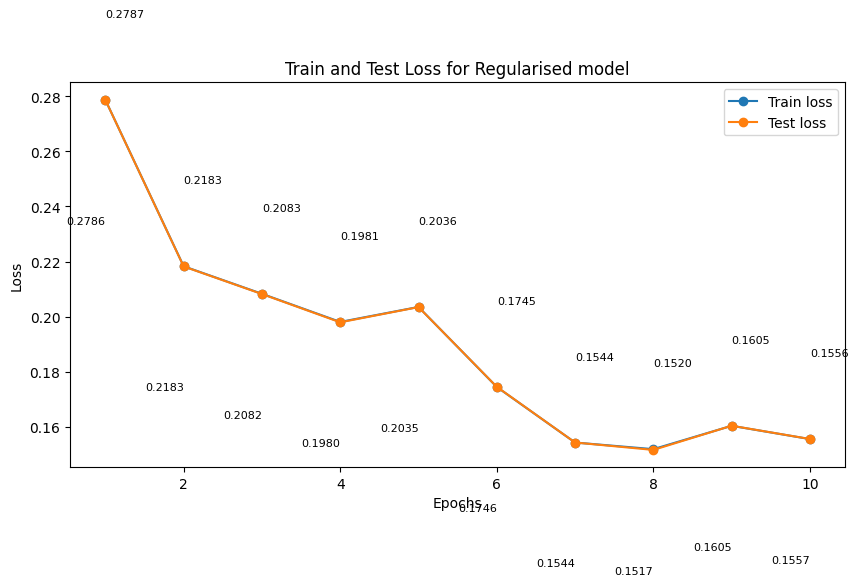

In [28]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

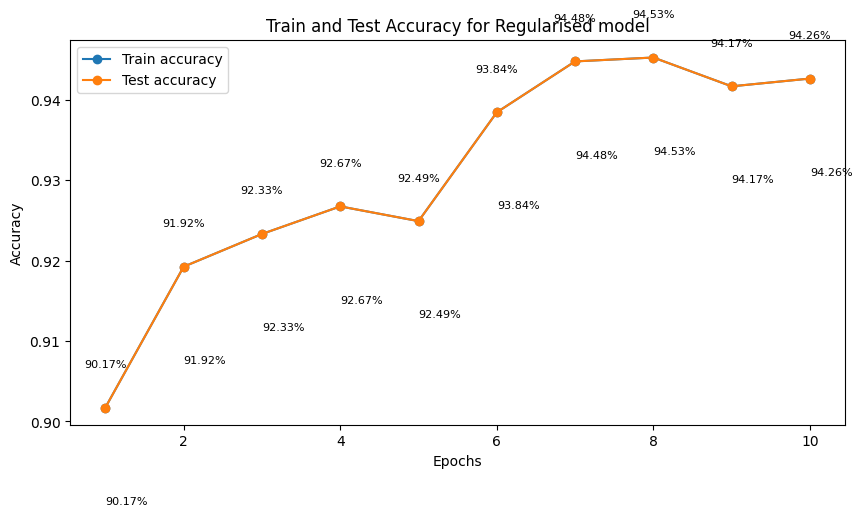

In [29]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font>Applying regularization techniques such as dropout, data augmentation, and weight decay significantly reduced overfitting. The non-regularized model showed high training accuracy but lower test accuracy, indicating overfitting. Regularization balanced the train and test performance, improving generalization. Data augmentation slowed convergence but enhanced robustness, while dropout and weight decay further stabilized performance across epochs.</font>

